Note: The preprocessing of the images as well as the Gaussian Process is done based on the method proposed by Jiaxuan You et al. in Deep Gaussian Process for Crop Yield Prediction Based on Remote Sensing Data, available at:
https://github.com/JiaxuanYou/crop_yield_prediction

In [ ]:
import os
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [ ]:
## Obtaining preprocessed histograms ##
download = drive.CreateFile({'id': '1fhS2Fzt9h-nPGv8VHY6Nphz02lUCg5qu'})
download.GetContentFile('histogram_all_2010.npz')
download = drive.CreateFile({'id': '1yEJi2jYT1jVyNkaw6qLvB9ZcE_GMoFwe'})
download.GetContentFile('histogram_all_2010_Mois.npz')

In [ ]:
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import time
print(tf.test.gpu_device_name())
predict_year = 2015

content = np.load('histogram_all_2010_Mois.npz')
# images[total, bins b, times T, bands d]
image_all = content['output_image']
yield_all = content['output_yield']
year_all = content['output_year']
locations_all = content['output_locations']
index_all = content['output_index']

# delete broken images
list_delete=[]
for i in range(image_all.shape[0]):
    if np.sum(image_all[i,:,:,:])<=287 or yield_all[i] == 0:
        if year_all[i]<2016:
            list_delete.append(i)

image_all = np.delete(image_all,list_delete,0)
yield_all = np.delete(yield_all,list_delete,0)
year_all = np.delete(year_all,list_delete, 0)
locations_all = np.delete(locations_all, list_delete, 0)
index_all = np.delete(index_all, list_delete, 0)

# keep major counties
list_keep=[]
for i in range(image_all.shape[0]):
    if (index_all[i,0]==5)or(index_all[i,0]==17)or(index_all[i,0]==18)or(index_all[i,0]==19)or(index_all[i,0]==20)or(index_all[i,0]==27)or(index_all[i,0]==29)or(index_all[i,0]==31)or(index_all[i,0]==38)or(index_all[i,0]==39)or(index_all[i,0]==46):
        list_keep.append(i)
image_all = image_all[list_keep,:,:,:]
yield_all = yield_all[list_keep]
year_all = year_all[list_keep]
locations_all = locations_all[list_keep,:]
index_all = index_all[list_keep,:]
print('total',image_all.shape)

# Split into train and validate
index_train = np.nonzero(year_all < predict_year)[0]
index_validate = np.nonzero(year_all == predict_year)[0]

## Calculate images mean and then subtract it
image_mean=np.mean(image_all[index_train],(0,1,2))
image_all = image_all - image_mean

image_train = image_all[index_train]
yield_train = yield_all[index_train]
image_validate = image_all[index_validate]
yield_validate = yield_all[index_validate]

print('train size',image_train.shape)
print('validate size',image_validate.shape)

/device:GPU:0
total (5275, 32, 32, 11)
train size (3763, 32, 32, 11)
validate size (667, 32, 32, 11)


# CNN

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
tf.keras.backend.clear_session()

cdrop = 0.1

model = models.Sequential()
model.add(layers.BatchNormalization(input_shape=(32,32,11)))
model.add(layers.Conv2D(filters=64, kernel_size=3, strides=1, padding='same', activation='relu'))
model.add(layers.MaxPooling2D(pool_size=2))
#model.add(layers.Dropout(cdrop))

model.add(layers.BatchNormalization())

model.add(layers.Conv2D(filters=128, kernel_size=3, strides=1, padding='same', activation='relu'))
#model.add(layers.MaxPooling2D(pool_size=2))
#model.add(layers.Dropout(cdrop))

model.add(layers.Flatten())
model.add(layers.Dense(units=1024, activation='relu'))

model.add(layers.Dense(units=1, activation='linear'))

optimizer = tf.keras.optimizers.Adam(learning_rate=5e-5)
loss = 'mean_absolute_error'
model.compile(optimizer=optimizer, loss = loss)

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization (BatchNo (None, 32, 32, 11)        44        
_________________________________________________________________
conv2d (Conv2D)              (None, 32, 32, 64)        6400      
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 32, 64)        256       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 128)       73856     
_________________________________________________________________
flatten (Flatten)            (None, 131072)            0         
_________________________________________________________________
dense (Dense)                (None, 1024)              134218752 
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 1

In [ ]:
from tensorflow.keras.callbacks import LearningRateScheduler
def decay_schedule(epoch, lr):
    # decay by 0.1 in these specific epochs
    if (epoch %5 == 0) and (epoch != 0):
        lr = lr * 0.1
    return lr

lr_scheduler = LearningRateScheduler(decay_schedule)
history = model.fit(image_train, yield_train, validation_data=(image_validate, yield_validate), epochs=10, batch_size=32, callbacks=[lr_scheduler], verbose=1)

Epoch 1/10
118/118 [==============================] - 6s 55ms/step - loss: 4.9916 - val_loss: 36.5804 - lr: 5.0000e-05
Epoch 2/10
118/118 [==============================] - 6s 53ms/step - loss: 3.0215 - val_loss: 23.1371 - lr: 5.0000e-05
Epoch 3/10
118/118 [==============================] - 6s 54ms/step - loss: 2.9939 - val_loss: 12.1019 - lr: 5.0000e-05
Epoch 4/10
118/118 [==============================] - 6s 54ms/step - loss: 2.4927 - val_loss: 7.7723 - lr: 5.0000e-05
Epoch 5/10
118/118 [==============================] - 6s 54ms/step - loss: 2.4440 - val_loss: 5.7432 - lr: 5.0000e-05
Epoch 6/10
118/118 [==============================] - 6s 54ms/step - loss: 1.6921 - val_loss: 4.9487 - lr: 5.0000e-06
Epoch 7/10
118/118 [==============================] - 6s 54ms/step - loss: 1.5446 - val_loss: 4.5735 - lr: 5.0000e-06
Epoch 8/10
118/118 [==============================] - 6s 54ms/step - loss: 1.4843 - val_loss: 4.1400 - lr: 5.0000e-06
Epoch 9/10
118/118 [==============================] -

End Train: 0.785  End Val: 3.817  Min Val: 3.572


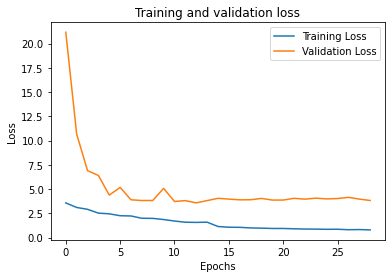

MAE of CNN: 3.821539069294394
RMSE of CNN: 5.049420256443399
R2 score of CNN: 0.7086516328724943


In [ ]:
train_loss = history.history['loss']
val_loss = history.history['val_loss']

print('End Train:', np.round(np.min(train_loss),3), ' End Val:', np.round(val_loss[-1],3), ' Min Val:', np.round(np.min(val_loss),3))
plt.plot(train_loss[1:], label='Training Loss')
plt.plot(val_loss[1:], label='Validation Loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs'); plt.ylabel('Loss')
plt.legend(); plt.show();

from sklearn.metrics import r2_score
preds = model.predict(image_validate).flatten()

RMSE_CNN = np.sqrt(np.mean((preds - yield_validate)**2))
MAE_CNN = np.mean(np.abs(preds - yield_validate))
r2_CNN = r2_score(yield_validate, preds)
print ("MAE of CNN:",MAE_CNN)
print ("RMSE of CNN:", RMSE_CNN)
print ("R2 score of CNN:",r2_CNN)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 64)        5248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 16, 128)       73856     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 8, 8, 128)         0         
_________________________________________________________________
flatten (Flatten)            (None, 8192)              0         
_________________________________________________________________
dense (Dense)                (None, 256)               2097408   
_________________________________________________________________
dense_1 (Dense)              (None, 512)               1

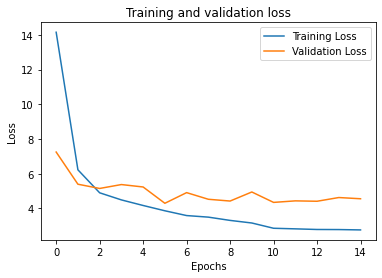

MAE of CNN: 4.555136803240816
RMSE of CNN: 6.021180317724795
R2 score of CNN: 0.608294962885612


In [ ]:
tf.keras.backend.clear_session()
cdrop = 0.1

model = models.Sequential()
model.add(layers.Conv2D(filters=64, kernel_size=3, strides=1, padding='same', activation='relu', input_shape=(32,32,9)))
model.add(layers.MaxPooling2D(pool_size=2))
#model.add(layers.Dropout(cdrop))

model.add(layers.Conv2D(filters=128, kernel_size=3, strides=1, padding='same', activation='relu'))
model.add(layers.MaxPooling2D(pool_size=2))
#model.add(layers.Dropout(cdrop))

model.add(layers.Flatten())
model.add(layers.Dense(units=256, activation='relu'))
model.add(layers.Dense(units=512, activation='relu'))
model.add(layers.Dense(units=1024, activation='relu'))

model.add(layers.Dense(units=1024, activation='linear'))
model.add(layers.Dense(units=1, activation='relu'))

optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
loss = 'mean_absolute_error'
model.compile(optimizer=optimizer, loss = loss, metrics=['mean_absolute_error'])

model.summary()

from tensorflow.keras.callbacks import LearningRateScheduler
def decay_schedule(epoch, lr):
    # decay by 0.1 in these specific epochs
    if (epoch %10 == 0) and (epoch != 0):
        lr = lr * 0.1
    return lr

lr_scheduler = LearningRateScheduler(decay_schedule)
history = model.fit(image_train, yield_train, validation_data=(image_validate, yield_validate), epochs=15, batch_size=32, callbacks=[lr_scheduler], verbose=0)

train_loss = history.history['loss']
val_loss = history.history['val_loss']

print('End Train:', np.round(np.min(train_loss),3), ' End Val:', np.round(val_loss[-1],3), ' Min Val:', np.round(np.min(val_loss),3))
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs'); plt.ylabel('Loss')
plt.legend(); plt.show();

from sklearn.metrics import r2_score
preds = model.predict(image_validate).flatten()

RMSE_CNN = np.sqrt(np.mean((preds - yield_validate)**2))
MAE_CNN = np.mean(np.abs(preds - yield_validate))
r2_CNN = r2_score(yield_validate, preds)
print ("MAE of CNN:",MAE_CNN)
print ("RMSE of CNN:", RMSE_CNN)
print ("R2 score of CNN:",r2_CNN)

In [ ]:
model.save('Best_model2.h5')

## GP

In [ ]:
GaussianProcess(predict_year)

Mean Absolute Error of CNN is 4.07286357736659
The RMSE of CNN model is 5.5029054273843965
R2 score of CNN is 0.6539700812661009
1 0.01 1 0.001
Mean Absolute Error of GP model is 3.594838306178447
The RMSE of GP model is 5.030420500285344
R2 score of GP model is 0.7108400557737069


3.594838306178447

In [ ]:
mae_list = []
const_list = [0.001,0.01,0.1,1,10,100,330]
for i in const_list:
    mae_GP = GaussianProcess(predict_year,i)
    mae_list.append(mae_GP)
plt.plot(list(range(len(const_list))),mae_list)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import pdist, squareform
from tensorflow.keras.models import Model
from sklearn import linear_model
from sklearn.metrics import r2_score
from joblib import Parallel, delayed
import multiprocessing
import logging

def GaussianProcess(year,l_s):

    preds = np.ravel(model.predict(image_all))
    model2 = Model(model.input, model.layers[-2].output)
    features = model2.predict(image_all)
    
    year_current = year
    
    # read
    pred_out = preds.copy()
    real_out = yield_all.copy()
    
    feature_out = features.copy()
    year_out = year_all.copy()
    locations_out=locations_all.copy()
    W = model.layers[-1].get_weights()[0].copy()
    b = [model.layers[-1].get_weights()[1]]
    W = np.concatenate((W,b))

#    '''2 divide dataset'''

    # get train, validate, test index
    c1 = year_out==year_current
    ind_test = np.where(c1)[0]
    #print ('shape of test set',ind_test.shape)

    c3 = year_out<year_current
    c4 = year_out>year_current-6
    # c5 = year_out!=2012
    # c3 = year_out==year_current-1
    ind_train = np.where(c3*c4)[0]
    index_reg = np.where(year_out!=2016)[0]

#    '''4 normalize all features'''
    bias = np.ones([feature_out.shape[0],1])
    feature_out = np.concatenate((feature_out,bias),axis=1)

    locations_mean = np.mean(locations_out, axis=0,keepdims=True)
    locations_std = np.mean(locations_out,axis=0,keepdims=True)
    locations_scale = np.amax(locations_out,axis=0)-np.amin(locations_out,axis=0)
    locations_out -= locations_mean
    locations_out /= locations_scale

    year_out = year_out[:,np.newaxis]
    year_mean = np.mean(year_out, axis=0,keepdims=True)
    year_std = np.mean(year_out,axis=0,keepdims=True)
    year_scale = np.amax(year_out,axis=0)-np.amin(year_out,axis=0)
    year_out -= year_mean
    year_out /= year_scale

    real_out = real_out[:,np.newaxis]
    # print 'year_out',np.amin(year_out),np.amax(year_out)

    # split dataset
    feat_train = feature_out[ind_train]
    feat_test = feature_out[ind_test]
    Y_train = real_out[ind_train]
    Y_test = real_out[ind_test]
    loc_train = locations_out[ind_train]
    loc_test = locations_out[ind_test]
    year_train = year_out[ind_train]
    year_test = year_out[ind_test]


    '''CNN baseline'''
    print ("Mean Absolute Error of CNN is",np.mean(np.abs(pred_out[ind_test]-real_out[ind_test,0])))
    print ("The RMSE of CNN model is", np.sqrt(np.mean((real_out[ind_test,0]-pred_out[ind_test])**2)))
    print ("R2 score of CNN is",r2_score(real_out[ind_test],pred_out[ind_test]))


#     '''
#         Gaussian Prcoess Model 3,
#         Linear GP as on page 28 of GP for machine learning
#         kernel: spatial*time
#     '''

    
    # 2010 without Moisture
    sigma=1
    #l_s = 1 #0.5
    l_t = 0.01
    noise = 1
    const = 0.001

    # 2010 with Moisture
    #sigma=1
    #l_s = 1.4 #0.5
    #l_t = 1.5
    #noise = 0.1
    #const = 1.5

    X_train = feat_train
    X_test = feat_test
    n1 = X_train.shape[0]
    n2 = X_test.shape[0]
    X = np.concatenate((X_train,X_test),axis=0)
    LOC = np.concatenate((loc_train,loc_test),axis=0)
    YEAR = np.concatenate((year_train,year_test),axis=0)
    pairwise_dists_loc = squareform(pdist(LOC, 'euclidean'))**2/l_s**2
    pairwise_dists_year = squareform(pdist(YEAR, 'euclidean'))**2/l_t**2

    n=np.zeros([n1+n2,n1+n2])
    n[0:n1,0:n1] += noise*np.identity(n1)
    kernel_mat_3 = sigma*sigma*(np.exp(-pairwise_dists_loc)*np.exp(-pairwise_dists_year))+n
    b = W
    B = np.identity(X_train.shape[1])

    print (l_s,l_t,noise,const)
    B /= const # B is diag, inverse is simplified
    K_inv = np.linalg.inv(kernel_mat_3[0:n1,0:n1])
    beta = np.linalg.inv(B+X_train.T.dot(K_inv).dot(X_train)).dot(X_train.T.dot(K_inv).dot(Y_train.reshape([n1,1]))+B.dot(b))
    Y_pred_3 = X_test.dot(beta) + kernel_mat_3[n1:(n1+n2),0:n1].dot(K_inv).dot(Y_train.reshape([n1,1])-X_train.dot(beta))

    RMSE_GP=np.sqrt(np.mean((Y_pred_3-real_out[ind_test,0].reshape(Y_pred_3.shape))**2))
    MAE_GP=np.mean(np.abs(Y_pred_3[:,0]-real_out[ind_test,0]))
    r2_GP=r2_score(real_out[ind_test,0],Y_pred_3[:,0])
    print ("Mean Absolute Error of GP model is",MAE_GP)
    print ("The RMSE of GP model is", RMSE_GP)
    print ("R2 score of GP model is",r2_GP)

    return (MAE_GP)

# LSMT-CNN

In [ ]:
LSTM_data = np.transpose(image_all, [0,2,1,3])
dim = LSTM_data.shape
LSTM_data = np.reshape(LSTM_data,[dim[0],-1,dim[2]*dim[3]])
print(LSTM_data.shape)

LSTM_image_train = LSTM_data[index_train]
LSTM_yield_train = yield_all[index_train]
LSTM_image_validate = LSTM_data[index_validate]
LSTM_yield_validate = yield_all[index_validate]

(5275, 32, 352)


In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
tf.keras.backend.clear_session()

model = models.Sequential()
model.add(layers.BatchNormalization(input_shape=(32, dim[2]*dim[3])))
model.add(layers.Conv1D(filters=64, kernel_size=3, strides=1, padding='causal', activation='relu'))
model.add(layers.Dropout(0.4))
model.add(layers.Conv1D(filters=128, kernel_size=3, strides=1, padding='causal', activation='relu'))
model.add(layers.BatchNormalization()) # <--- This is good
#model.add(layers.Dropout(0.1))

model.add(layers.LSTM(128))
#model.add(layers.Dropout(0.1))


model.add(layers.Flatten())
model.add(layers.Dense(units=512, activation='relu'))
model.add(layers.Dense(units=1024, activation='relu'))
model.add(layers.Dense(units=1, activation='linear'))

optimizer = tf.keras.optimizers.Adam(learning_rate=5e-5)
loss = 'mean_absolute_error'
model.compile(optimizer=optimizer, loss = loss)

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization (BatchNo (None, 32, 352)           1408      
_________________________________________________________________
conv1d (Conv1D)              (None, 32, 64)            67648     
_________________________________________________________________
dropout (Dropout)            (None, 32, 64)            0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 32, 128)           24704     
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 128)           512       
_________________________________________________________________
lstm (LSTM)                  (None, 128)               131584    
_________________________________________________________________
flatten (Flatten)            (None, 128)               0

In [ ]:
from tensorflow.keras.callbacks import LearningRateScheduler
def decay_schedule(epoch, lr):
    # decay by 0.1 in these specific epochs
    if (epoch %15 == 0) and (epoch != 0):
        lr = lr * 0.1
    return lr

lr_scheduler = LearningRateScheduler(decay_schedule)
history = model.fit(LSTM_image_train, LSTM_yield_train, validation_data=(LSTM_image_validate, LSTM_yield_validate), epochs=30, batch_size=32, callbacks=[lr_scheduler], verbose=1)

Epoch 1/30
118/118 [==============================] - 3s 21ms/step - loss: 29.7772 - val_loss: 9.5868 - lr: 5.0000e-05
Epoch 2/30
118/118 [==============================] - 2s 18ms/step - loss: 6.8059 - val_loss: 6.6348 - lr: 5.0000e-05
Epoch 3/30
118/118 [==============================] - 2s 18ms/step - loss: 4.8372 - val_loss: 7.8954 - lr: 5.0000e-05
Epoch 4/30
118/118 [==============================] - 2s 19ms/step - loss: 4.3468 - val_loss: 4.9273 - lr: 5.0000e-05
Epoch 5/30
118/118 [==============================] - 2s 18ms/step - loss: 4.0520 - val_loss: 3.8596 - lr: 5.0000e-05
Epoch 6/30
118/118 [==============================] - 2s 18ms/step - loss: 3.9016 - val_loss: 3.6274 - lr: 5.0000e-05
Epoch 7/30
118/118 [==============================] - 2s 18ms/step - loss: 3.7968 - val_loss: 3.6124 - lr: 5.0000e-05
Epoch 8/30
118/118 [==============================] - 2s 18ms/step - loss: 3.6626 - val_loss: 3.7857 - lr: 5.0000e-05
Epoch 9/30
118/118 [==============================] - 2

End Train: 3.118  End Val: 3.349  Min Val: 3.338


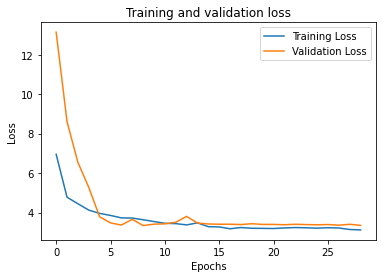

MAE of CNN: 3.3425155673963554
RMSE of CNN: 4.674778411852934
R2 score of CNN: 0.7502809856290265


In [ ]:
train_loss = history.history['loss']
val_loss = history.history['val_loss']

print('End Train:', np.round(np.min(train_loss),3), ' End Val:', np.round(val_loss[-1],3), ' Min Val:', np.round(np.min(val_loss),3))
plt.plot(train_loss[1:], label='Training Loss')
plt.plot(val_loss[1:], label='Validation Loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs'); plt.ylabel('Loss')
plt.legend(); plt.show();

from sklearn.metrics import r2_score
preds = model.predict(LSTM_image_validate).flatten()

RMSE_CNN = np.sqrt(np.mean((preds - LSTM_yield_validate)**2))
MAE_CNN = np.mean(np.abs(preds - LSTM_yield_validate))
r2_CNN = r2_score(LSTM_yield_validate, preds)
print ("MAE of CNN:",MAE_CNN)
print ("RMSE of CNN:", RMSE_CNN)
print ("R2 score of CNN:",r2_CNN)

In [ ]:
#from google.colab import drive
import torch
model.save('Best_model_moisture.h5')
model_file = drive.CreateFile({'title' : 'Best_model_moisture.h5'})
model_file.SetContentFile('Best_model_moisture.h5')
model_file.Upload()

## GP

In [ ]:
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import time
print(tf.test.gpu_device_name())
predict_year = 2012

content = np.load('histogram_all_2010_Mois.npz')
# images[total, bins b, times T, bands d]
image_all = content['output_image']
yield_all = content['output_yield']
year_all = content['output_year']
locations_all = content['output_locations']
index_all = content['output_index']

# delete broken images
list_delete=[]
for i in range(image_all.shape[0]):
    if np.sum(image_all[i,:,:,:])<=287 or yield_all[i] == 0:
        if year_all[i]<2016:
            list_delete.append(i)

image_all = np.delete(image_all,list_delete,0)
yield_all = np.delete(yield_all,list_delete,0)
year_all = np.delete(year_all,list_delete, 0)
locations_all = np.delete(locations_all, list_delete, 0)
index_all = np.delete(index_all, list_delete, 0)

# keep major counties
list_keep=[]
for i in range(image_all.shape[0]):
    if (index_all[i,0]==5)or(index_all[i,0]==17)or(index_all[i,0]==18)or(index_all[i,0]==19)or(index_all[i,0]==20)or(index_all[i,0]==27)or(index_all[i,0]==29)or(index_all[i,0]==31)or(index_all[i,0]==38)or(index_all[i,0]==39)or(index_all[i,0]==46):
        list_keep.append(i)
image_all = image_all[list_keep,:,:,:]
yield_all = yield_all[list_keep]
year_all = year_all[list_keep]
locations_all = locations_all[list_keep,:]
index_all = index_all[list_keep,:]
print('total',image_all.shape)

# split into train and validate
index_train = np.nonzero(year_all < predict_year)[0]
index_validate = np.nonzero(year_all == predict_year)[0]

# calc train image mean (for each band), and then detract (broadcast)
image_mean=np.mean(image_all[index_train],(0,1,2))
image_all = image_all - image_mean

image_train = image_all[index_train]
yield_train = yield_all[index_train]
image_validate = image_all[index_validate]
yield_validate = yield_all[index_validate]

LSTM_data = np.transpose(image_all, [0,2,1,3])
dim = LSTM_data.shape
LSTM_data = np.reshape(LSTM_data,[dim[0],-1,dim[2]*dim[3]])
print(LSTM_data.shape)

LSTM_image_train = LSTM_data[index_train]
LSTM_yield_train = yield_all[index_train]
LSTM_image_validate = LSTM_data[index_validate]
LSTM_yield_validate = yield_all[index_validate]

/device:GPU:0
total (5275, 32, 32, 11)
(5275, 32, 352)


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import pdist, squareform
from tensorflow.keras.models import Model
from sklearn import linear_model
from sklearn.metrics import r2_score
from joblib import Parallel, delayed
import multiprocessing

def GaussianProcess(year):
    preds = np.ravel(model.predict(LSTM_data))
    model2 = Model(model.input, model.layers[-2].output)
    features = model2.predict(LSTM_data)
    
    year_current = year
    
    # read
    pred_out = preds.copy()
    real_out = yield_all.copy()
    
    feature_out = features.copy()
    year_out = year_all.copy()
    locations_out=locations_all.copy()
    W = model.layers[-1].get_weights()[0].copy()
    b = [model.layers[-1].get_weights()[1]]
    W = np.concatenate((W,b))

#    '''2 divide dataset'''

    # get train, validate, test index
    c1 = year_out==year_current
    ind_test = np.where(c1)[0]
    #print ('shape of test set',ind_test.shape)

    c3 = year_out<year_current
    c4 = year_out>year_current-6
    # c5 = year_out!=2012
    # c3 = year_out==year_current-1
    ind_train = np.where(c3*c4)[0]
    index_reg = np.where(year_out!=2016)[0]

#    '''4 normalize all features'''
    bias = np.ones([feature_out.shape[0],1])
    feature_out = np.concatenate((feature_out,bias),axis=1)

    locations_mean = np.mean(locations_out, axis=0,keepdims=True)
    locations_std = np.mean(locations_out,axis=0,keepdims=True)
    locations_scale = np.amax(locations_out,axis=0)-np.amin(locations_out,axis=0)
    locations_out -= locations_mean
    locations_out /= locations_scale

    year_out = year_out[:,np.newaxis]
    year_mean = np.mean(year_out, axis=0,keepdims=True)
    year_std = np.mean(year_out,axis=0,keepdims=True)
    year_scale = np.amax(year_out,axis=0)-np.amin(year_out,axis=0)
    year_out -= year_mean
    year_out /= year_scale

    real_out = real_out[:,np.newaxis]
    # print 'year_out',np.amin(year_out),np.amax(year_out)

    # split dataset
    feat_train = feature_out[ind_train]
    feat_test = feature_out[ind_test]
    Y_train = real_out[ind_train]
    Y_test = real_out[ind_test]
    loc_train = locations_out[ind_train]
    loc_test = locations_out[ind_test]
    year_train = year_out[ind_train]
    year_test = year_out[ind_test]

    '''CNN baseline'''
    print ("Mean Absolute Error of CNN is",np.mean(np.abs(pred_out[ind_test]-real_out[ind_test,0])))
    print ("The RMSE of CNN model is", np.sqrt(np.mean((real_out[ind_test,0]-pred_out[ind_test])**2)))
    print ("R2 score of CNN is",r2_score(real_out[ind_test],pred_out[ind_test]))

#     '''
#         Gaussian Prcoess Model 3,
#         Linear GP as on page 28 of GP for machine learning
#         kernel: spatial*time
#     '''
    
    sigma=1
    # 2010 without Moisture
    #l_s = 10 #0.5
    #l_t = 0.1
    #noise = 1
    #const = 0.1

    # 2010 with Moisture
    l_s = 0.001 #0.5
    l_t = 10
    noise = 1
    const = 1

    X_train = feat_train
    X_test = feat_test
    n1 = X_train.shape[0]
    n2 = X_test.shape[0]
    X = np.concatenate((X_train,X_test),axis=0)
    LOC = np.concatenate((loc_train,loc_test),axis=0)
    YEAR = np.concatenate((year_train,year_test),axis=0)
    pairwise_dists_loc = squareform(pdist(LOC, 'euclidean'))**2/l_s**2
    pairwise_dists_year = squareform(pdist(YEAR, 'euclidean'))**2/l_t**2

    n=np.zeros([n1+n2,n1+n2])
    n[0:n1,0:n1] += noise*np.identity(n1)
    kernel_mat_3 = sigma*sigma*(np.exp(-pairwise_dists_loc)*np.exp(-pairwise_dists_year))+n
    b = W
    B = np.identity(X_train.shape[1])

    print (l_s,l_t,noise,const)
    B /= const # B is diag, inverse is simplified
    K_inv = np.linalg.inv(kernel_mat_3[0:n1,0:n1])
    beta = np.linalg.inv(B+X_train.T.dot(K_inv).dot(X_train)).dot(X_train.T.dot(K_inv).dot(Y_train.reshape([n1,1]))+B.dot(b))
    Y_pred_3 = X_test.dot(beta) + kernel_mat_3[n1:(n1+n2),0:n1].dot(K_inv).dot(Y_train.reshape([n1,1])-X_train.dot(beta))

    RMSE_GP=np.sqrt(np.mean((Y_pred_3-real_out[ind_test,0].reshape(Y_pred_3.shape))**2))
    MAE_GP=np.mean(np.abs(Y_pred_3[:,0]-real_out[ind_test,0]))
    r2_GP=r2_score(real_out[ind_test,0],Y_pred_3[:,0])
    print ("Mean Absolute Error of GP model is",MAE_GP)
    print ("The RMSE of GP model is", RMSE_GP)
    print ("R2 score of GP model is",r2_GP)

    return (MAE_GP)

In [ ]:
GaussianProcess(predict_year)

Mean Absolute Error of CNN is 3.656536695242561
The RMSE of CNN model is 4.649409334216561
R2 score of CNN is 0.8206335929799294
0.001 10 1 1
Mean Absolute Error of GP model is 2.752770558534906
The RMSE of GP model is 3.5954816779490364
R2 score of GP model is 0.8927345887174292


2.752770558534906

Mean Absolute Error of CNN is 3.3425155673963554
The RMSE of CNN model is 4.674778411852934
R2 score of CNN is 0.7502809856290265
0.001 10 1 0.001
Mean Absolute Error of GP model is 3.6082810994905254
The RMSE of GP model is 4.709668004816262
R2 score of GP model is 0.746539585867195
Mean Absolute Error of CNN is 3.3425155673963554
The RMSE of CNN model is 4.674778411852934
R2 score of CNN is 0.7502809856290265
0.001 10 1 0.01
Mean Absolute Error of GP model is 3.5409314513260375
The RMSE of GP model is 4.667883901202952
R2 score of GP model is 0.7510170294158572
Mean Absolute Error of CNN is 3.3425155673963554
The RMSE of CNN model is 4.674778411852934
R2 score of CNN is 0.7502809856290265
0.001 10 1 0.1
Mean Absolute Error of GP model is 3.5228019724527218
The RMSE of GP model is 4.666588990558022
R2 score of GP model is 0.7511551502372423
Mean Absolute Error of CNN is 3.3425155673963554
The RMSE of CNN model is 4.674778411852934
R2 score of CNN is 0.7502809856290265
0.001 10 1 1
Mea

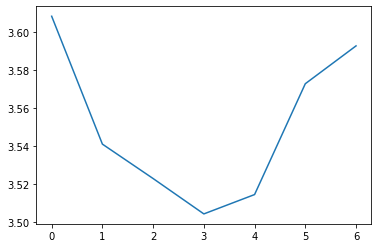

In [ ]:
## Hyperparameter Tuning ##

mae_list = []
const_list = [0.001,0.01,0.1,1,10,100,330]
for i in const_list:
    mae_GP = GaussianProcess(predict_year,i)
    mae_list.append(mae_GP)
plt.plot(list(range(len(const_list))),mae_list)